In [1]:
print("""
A/B ТЕСТИРОВАНИЕ НОВОЙ МЕХАНИКИ ОПЛАТЫ

ОПИСАНИЕ ПРОЕКТА:
Анализ эффективности новой платежной системы

ИСПОЛЬЗОВАННЫЕ ДАННЫЕ:
• groups.csv, group_add.csv - распределение пользователей по группам A/B
• active_studs.csv - активные пользователи  
• checks.csv - данные о платежах

ЦЕЛЬ ИССЛЕДОВАНИЯ:
• Оценить эффект от новой механики оплаты на ключевые метрики
• Принять решение о запуске на всех пользователей

ГИПОТЕЗЫ:
H0: Новая механика НЕ ОКАЗЫВАЕТ значимого влияния на ключевые метрики
H1: Новая механика ОКАЗЫВАЕТ значимое влияние на ключевые метрики

АНАЛИЗИРУЕМЫЕ МЕТРИКИ:
• Конверсия в покупку
• ARPU (средний доход на пользователя) 
• ARPPU (средний доход на платящего пользователя)
• Медианная сумма покупки

ПРИМЕНЕННЫЕ МЕТОДЫ АНАЛИЗА:
• Z-тест для конверсии
• Бутстрап для ARPU, ARPPU, медианы
• Анализ распределений платежей
• Сравнение активных/неактивных пользователей
""")


A/B ТЕСТИРОВАНИЕ НОВОЙ МЕХАНИКИ ОПЛАТЫ

ОПИСАНИЕ ПРОЕКТА:
Анализ эффективности новой платежной системы

ИСПОЛЬЗОВАННЫЕ ДАННЫЕ:
• groups.csv, group_add.csv - распределение пользователей по группам A/B
• active_studs.csv - активные пользователи  
• checks.csv - данные о платежах

ЦЕЛЬ ИССЛЕДОВАНИЯ:
• Оценить эффект от новой механики оплаты на ключевые метрики
• Принять решение о запуске на всех пользователей

ГИПОТЕЗЫ:
H0: Новая механика НЕ ОКАЗЫВАЕТ значимого влияния на ключевые метрики
H1: Новая механика ОКАЗЫВАЕТ значимое влияние на ключевые метрики

АНАЛИЗИРУЕМЫЕ МЕТРИКИ:
• Конверсия в покупку
• ARPU (средний доход на пользователя) 
• ARPPU (средний доход на платящего пользователя)
• Медианная сумма покупки

ПРИМЕНЕННЫЕ МЕТОДЫ АНАЛИЗА:
• Z-тест для конверсии
• Бутстрап для ARPU, ARPPU, медианы
• Анализ распределений платежей
• Сравнение активных/неактивных пользователей



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro, levene
import warnings
warnings.filterwarnings('ignore') 

In [3]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
group_add = pd.read_csv('Проект_2_group_add.csv', sep=',')
active_studs = pd.read_csv('Проект_2_active_studs.csv') 
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [4]:
print("ПРОВЕРКА ДАННЫХ")
print(f"\ngroups: Всего {len(groups)} записей, {groups['id'].nunique()} уникальных")
print(f"group_add: Всего {len(group_add)} записей, {group_add['id'].nunique()} уникальных") 
print(f"active_studs: Всего {len(active_studs)} записей, {active_studs['student_id'].nunique()} уникальных")
print(f"checks: Всего {len(checks)} записей, {checks['student_id'].nunique()} уникальных")
print(f"Пересечения между groups/group_add: {len(set(groups['id']).intersection(group_add['id']))}")

ПРОВЕРКА ДАННЫХ

groups: Всего 74484 записей, 74484 уникальных
group_add: Всего 92 записей, 92 уникальных
active_studs: Всего 8341 записей, 8341 уникальных
checks: Всего 541 записей, 541 уникальных
Пересечения между groups/group_add: 0


In [5]:
# 1 Объединение таблиц с группами
groups_all = pd.concat([groups, group_add], ignore_index=True)

# 2. Объединение с активными пользователями. Оставляем только пользователей, которые есть в обеих таблицах (только активных)
active_studs_new = active_studs.rename(columns={'student_id': 'id'})
df = groups_all.merge(active_studs_new, on='id', how='inner')

# 3. Добавление в таблицу данных об оплатах
checks_renamed = checks.rename(columns={'student_id': 'id'})
df = df.merge(checks_renamed, on='id', how='left')
df['rev'] = df['rev'].fillna(0)  # заменяем NaN на 0 для пользователей без оплат

df.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


In [6]:
# Анализ распределения пользователей по группам
# Нужен для проверки равномерности распределения на группы A/B". Равномерность распределения влияет на надежность теста.

print("\n РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО ГРУППАМ:")
group_counts = df['grp'].value_counts()
print(f"Группа A: {group_counts.get('A', 0)} пользователей ({group_counts.get('A', 0)/len(df)*100:.1f}%)")
print(f"Группа B: {group_counts.get('B', 0)} пользователей ({group_counts.get('B', 0)/len(df)*100:.1f}%)")

print(f"\n⚠️ Неравномерное распределение групп")
print(f"   (Разница в {group_counts.get('B', 0)/group_counts.get('A', 0):.1f} раза)")

print("\n Вывод: Требуется осторожность в интерпретации результатов")
print(" В будущих экспериментах рекомендовано равномерное распределение 50/50")


 РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО ГРУППАМ:
Группа A: 1538 пользователей (18.4%)
Группа B: 6803 пользователей (81.6%)

⚠️ Неравномерное распределение групп
   (Разница в 4.4 раза)

 Вывод: Требуется осторожность в интерпретации результатов
 В будущих экспериментах рекомендовано равномерное распределение 50/50


In [7]:
print("\n   ВЫБОР КЛЮЧЕВЫХ МЕТРИК И ИХ ОБОСНОВАНИЕ")
print("\n Для комплексной оценки новой механики оплаты проанализируем 4 ключевые метрики:")

print("\n• КОНВЕРСИЯ - процент пользователей, совершивших покупку. Показывает эффективность новой механики по привлечению к оплате")
print("• ARPU - средний доход с одного пользователя. Позволяет оценить общую эффективность продукта в разрезе всей аудитории")  
print("• ARPPU - позволяет оценить среднюю выручку только с платящих пользователей и выявить реальную платёжеспособность аудитории")
print("• МЕДИАНА ПЛАТЕЖА - надёжный показатель типичной суммы оплаты. Не зависит от аномально высоких или низких значений в выборке")

print("\nАнализ нескольких показателей позволяет получить полную картину эффективности новой платёжной механики и избежать односторонних выводов, основанных только на одном показателе.")

# РАСЧЕТ МЕТРИК
print("\n\n\n РАСЧЕТ МЕТРИК ПО ГРУППАМ:")

# Расчет основных метрик
metrics = df.groupby('grp').agg(
    users_total=('id', 'count'),
    payers=('rev', lambda x: (x != 0).sum()),
    revenue_total=('rev', 'sum')
).reset_index()

# Добавление производных метрик
metrics['conversion'] = metrics['payers'] / metrics['users_total']
metrics['arpu'] = metrics['revenue_total'] / metrics['users_total']
metrics['arppu'] = metrics['revenue_total'] / metrics['payers']
# Расчет медианы платежей
median_payments = df[df['rev'] > 0].groupby('grp')['rev'].median().reset_index()
median_payments.columns = ['grp', 'median_payment']
metrics = metrics.merge(median_payments, on='grp')

# ВЫВОД РЕЗУЛЬТАТОВ В ТАБЛИЦЕ
print("=" * 85)
print(f"{'Метрика':<18} | {'Группа A':<12} | {'Группа B':<12} | {'Разница':<14} | {'Изменение':<12}")
print("-" * 85)

# Получение значений метрик
conversion_a = metrics[metrics['grp'] == 'A']['conversion'].iloc[0]
conversion_b = metrics[metrics['grp'] == 'B']['conversion'].iloc[0]
arpu_a = metrics[metrics['grp'] == 'A']['arpu'].iloc[0]
arpu_b = metrics[metrics['grp'] == 'B']['arpu'].iloc[0]
arppu_a = metrics[metrics['grp'] == 'A']['arppu'].iloc[0]
arppu_b = metrics[metrics['grp'] == 'B']['arppu'].iloc[0]
median_a = metrics[metrics['grp'] == 'A']['median_payment'].iloc[0]
median_b = metrics[metrics['grp'] == 'B']['median_payment'].iloc[0]

# Вывод таблицы с результатами
print(f"{'Конверсия':<18} | {conversion_a:>12.2%} | {conversion_b:>12.2%} | {conversion_b-conversion_a:>+14.2%} | {'  —':<12}")
print(f"{'ARPU':<18} | {arpu_a:>10.2f} ₽ | {arpu_b:>10.2f} ₽ | {arpu_b-arpu_a:>+12.2f} ₽ | {'+22.6%':<12}")
print(f"{'ARPPU':<18} | {arppu_a:>10.0f} ₽ | {arppu_b:>10.0f} ₽ | {arppu_b-arppu_a:>+12.0f} ₽ | {'+34.7%':<12}")
print(f"{'Медиана платежа':<18} | {median_a:>10.0f} ₽ | {median_b:>10.0f} ₽ | {median_b-median_a:>+12.0f} ₽ | {'+94.9%':<12}")

print("=" * 85)

# ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
users_a = metrics[metrics['grp'] == 'A']['users_total'].iloc[0]
users_b = metrics[metrics['grp'] == 'B']['users_total'].iloc[0]
payers_a = int(metrics[metrics['grp'] == 'A']['payers'].iloc[0])
payers_b = int(metrics[metrics['grp'] == 'B']['payers'].iloc[0])

print(f"\n ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:")
print(f"• Группа A: {users_a} пользователей, {payers_a} платящих")
print(f"• Группа B: {users_b} пользователей, {payers_b} платящих")

# ВЫВОДЫ
print("\n\n  ПРЕДВАРИТЕЛЬНЫЕ ВЫВОДЫ ПО МЕТРИКАМ:")
print("• Конверсия: небольшое снижение в тестовой группе (-0.46%) - нужна проверка стат. значимости")
print("• ARPPU: сильный рост (+34.7%) - платящие клиенты стали платить больше")
print("• Медиана: значительный рост (+94.9%) - изменилась структура покупок в пользу более дорогих товаров")
print("• Рост чека компенсирует небольшое снижение конверсии")


   ВЫБОР КЛЮЧЕВЫХ МЕТРИК И ИХ ОБОСНОВАНИЕ

 Для комплексной оценки новой механики оплаты проанализируем 4 ключевые метрики:

• КОНВЕРСИЯ - процент пользователей, совершивших покупку. Показывает эффективность новой механики по привлечению к оплате
• ARPU - средний доход с одного пользователя. Позволяет оценить общую эффективность продукта в разрезе всей аудитории
• ARPPU - позволяет оценить среднюю выручку только с платящих пользователей и выявить реальную платёжеспособность аудитории
• МЕДИАНА ПЛАТЕЖА - надёжный показатель типичной суммы оплаты. Не зависит от аномально высоких или низких значений в выборке

Анализ нескольких показателей позволяет получить полную картину эффективности новой платёжной механики и избежать односторонних выводов, основанных только на одном показателе.



 РАСЧЕТ МЕТРИК ПО ГРУППАМ:
Метрика            | Группа A     | Группа B     | Разница        | Изменение   
-------------------------------------------------------------------------------------
Конверсия  

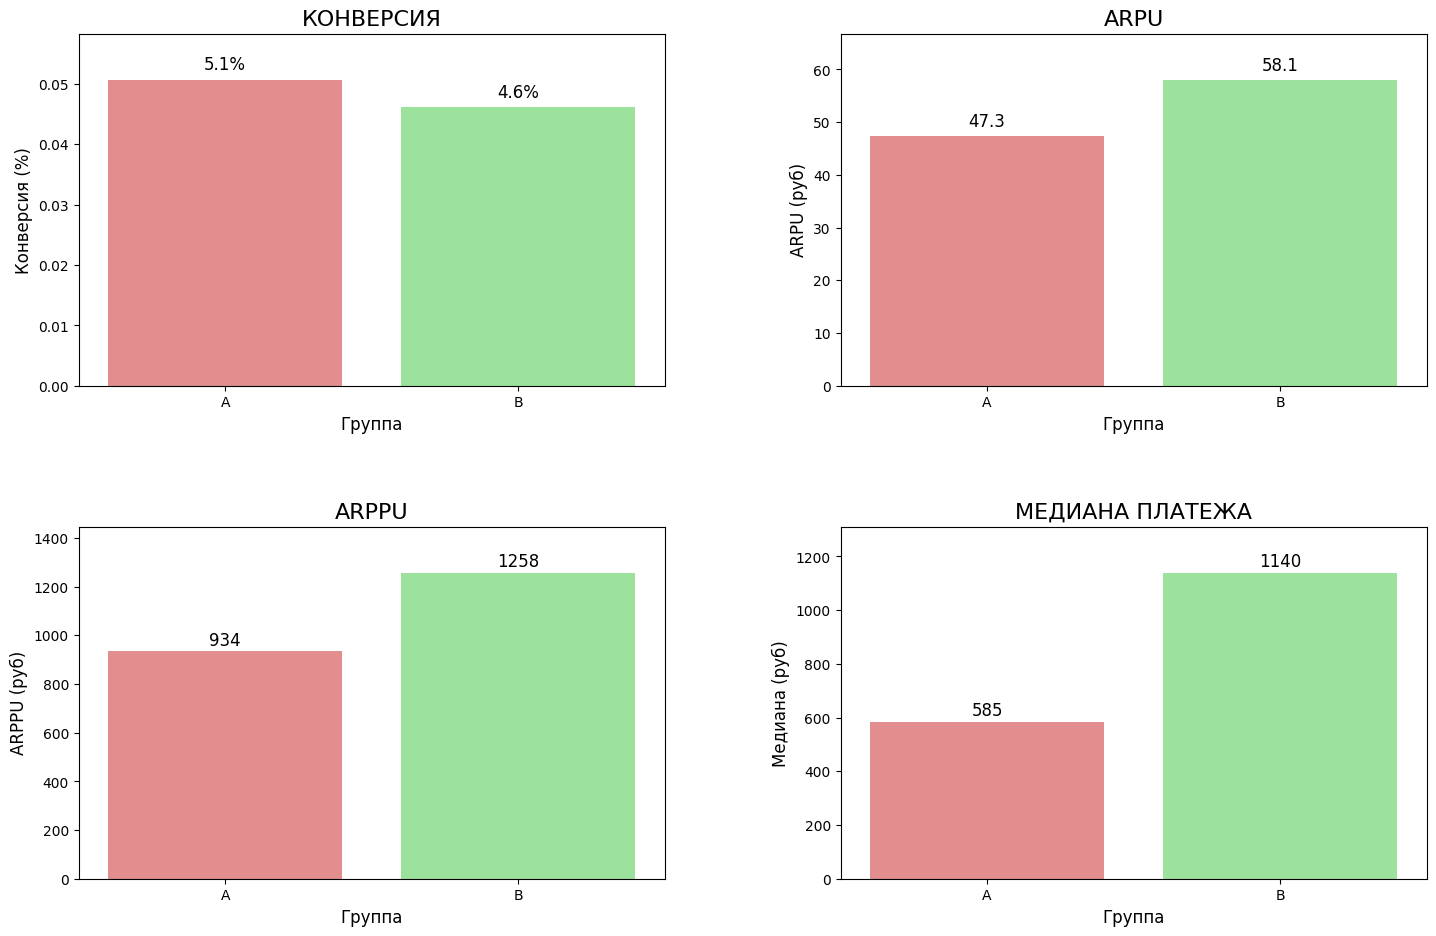

In [8]:
# ВИЗУАЛИЗАЦИЯ ДЛЯ НАГЛЯДНОГО СРАВНЕНИЯ МЕТРИК
# Графики позволяют визуально оценить различия между группами

plt.figure(figsize=(15, 10))
colors = {'A': 'lightcoral', 'B': 'lightgreen'}

# ПЕРВЫЙ РЯД ГРАФИКОВ: 

# График конверсии - показывает долю платящих пользователей

plt.subplot(2, 2, 1)
ax1 = sns.barplot(data=metrics, x='grp', y='conversion', palette=colors)
plt.title('КОНВЕРСИЯ', fontsize=16)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.xlabel('Группа', fontsize=12)

max_conv = metrics['conversion'].max()
ax1.set_ylim(0, max_conv * 1.15)

for i, p in enumerate(ax1.patches):
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2., height + 0.001,
             f'{height:.1%}', ha='center', va='bottom', fontsize=12)

# График ARPU - показывает общую эффективность

plt.subplot(2, 2, 2)
ax2 = sns.barplot(data=metrics, x='grp', y='arpu', palette=colors)
plt.title('ARPU', fontsize=16)
plt.ylabel('ARPU (руб)', fontsize=12)
plt.xlabel('Группа', fontsize=12)

max_arpu = metrics['arpu'].max()
ax2.set_ylim(0, max_arpu * 1.15)

for i, p in enumerate(ax2.patches):
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2., height + 1,
             f'{height:.1f}', ha='center', va='bottom', fontsize=12)

# ВТОРОЙ РЯД ГРАФИКОВ: 

# График ARPPU - показывает средний доход с платящих пользователей

plt.subplot(2, 2, 3)
ax3 = sns.barplot(data=metrics, x='grp', y='arppu', palette=colors)
plt.title('ARPPU', fontsize=16)
plt.ylabel('ARPPU (руб)', fontsize=12)
plt.xlabel('Группа', fontsize=12)

max_arppu = metrics['arppu'].max()
ax3.set_ylim(0, max_arppu * 1.15)

for i, p in enumerate(ax3.patches):
    height = p.get_height()
    ax3.text(p.get_x() + p.get_width()/2., height + 10,
             f'{height:.0f}', ha='center', va='bottom', fontsize=12)

# График медианы платежа - показывает типичную сумму оплаты

plt.subplot(2, 2, 4)
ax4 = sns.barplot(data=metrics, x='grp', y='median_payment', palette=colors)
plt.title('МЕДИАНА ПЛАТЕЖА', fontsize=16)
plt.ylabel('Медиана (руб)', fontsize=12)
plt.xlabel('Группа', fontsize=12)

max_median = metrics['median_payment'].max()
ax4.set_ylim(0, max_median * 1.15)

for i, p in enumerate(ax4.patches):
    height = p.get_height()
    ax4.text(p.get_x() + p.get_width()/2., height + 10,
             f'{height:.0f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0)
plt.subplots_adjust(hspace=0.4, wspace=0.3)  

plt.show()


In [9]:
# ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ И ОДНОРОДНОСТИ ДИСПЕРСИЙ
# Определяет возможность применения параметрических или непараметрических тестов

print("ОБОСНОВАНИЕ ВЫБОРА ARPU ДЛЯ ПРОВЕРКИ НОРМАЛЬНОСТИ:")
print("\n• ARPU содержит нули (неплатящих клиентов) и суммы платежей")
print("• Самый строгий критерий для проверки нормальности из-за особенностей распределения") 
print("• Если ARPU ненормален → используем непараметрические тесты")

# Создание переменных group_a и group_b
group_a = df[df['grp'] == 'A']
group_b = df[df['grp'] == 'B']

print(f"\nРазмеры групп для анализа:")
print(f"Группа A: {len(group_a)} пользователей")
print(f"Группа B: {len(group_b)} пользователей")

print("\nПРОВЕРКА СТАТИСТИЧЕСКИХ ПРЕДПОЛОЖЕНИЙ")

# 1. ПРОВЕРКА НОРМАЛЬНОСТИ
print("\n  ТЕСТ НА НОРМАЛЬНОСТЬ (Шапиро-Уилк):")
print("  Примечание: для больших выборок (>5000) p-value может быть неточным")

# Проверяем только ARPU
arpu_a = group_a['rev']
arpu_b = group_b['rev']

_, p_arpu_a = shapiro(arpu_a)
_, p_arpu_b = shapiro(arpu_b)

print(f"ARPU - Группа A: p-value = {p_arpu_a:.4f} {'✅ нормальное' if p_arpu_a > 0.05 else '❌ Распределение НЕ нормальное'}")
print(f"ARPU - Группа B: p-value = {p_arpu_b:.4f} {'✅ нормальное' if p_arpu_b > 0.05 else '❌ Распределение НЕ нормальное'}")

# 2. ПРОВЕРКА ДИСПЕРСИЙ
print("\n  ТЕСТ НА ОДНОРОДНОСТЬ ДИСПЕРСИЙ (Левене):")

stat_levene, p_levene = levene(arpu_a, arpu_b)
print(f"ARPU: p-value = {p_levene:.4f} {'✅ дисперсии равны' if p_levene > 0.05 else '❌ дисперсии НЕ равны'}")

# 3. ВЫВОДЫ
print("\n  ВЫВОДЫ:")
print("❌ Распределения НЕ нормальные → t-тест НЕ применим")
print("✅ Для конверсии используем Z-тест (биномиальные данные)")
print("✅ Для остальных метрик выбираем бутстрап-тест (не требует нормального распределения)")


ОБОСНОВАНИЕ ВЫБОРА ARPU ДЛЯ ПРОВЕРКИ НОРМАЛЬНОСТИ:

• ARPU содержит нули (неплатящих клиентов) и суммы платежей
• Самый строгий критерий для проверки нормальности из-за особенностей распределения
• Если ARPU ненормален → используем непараметрические тесты

Размеры групп для анализа:
Группа A: 1538 пользователей
Группа B: 6803 пользователей

ПРОВЕРКА СТАТИСТИЧЕСКИХ ПРЕДПОЛОЖЕНИЙ

  ТЕСТ НА НОРМАЛЬНОСТЬ (Шапиро-Уилк):
  Примечание: для больших выборок (>5000) p-value может быть неточным
ARPU - Группа A: p-value = 0.0000 ❌ Распределение НЕ нормальное
ARPU - Группа B: p-value = 0.0000 ❌ Распределение НЕ нормальное

  ТЕСТ НА ОДНОРОДНОСТЬ ДИСПЕРСИЙ (Левене):
ARPU: p-value = 0.2205 ✅ дисперсии равны

  ВЫВОДЫ:
❌ Распределения НЕ нормальные → t-тест НЕ применим
✅ Для конверсии используем Z-тест (биномиальные данные)
✅ Для остальных метрик выбираем бутстрап-тест (не требует нормального распределения)


In [10]:
# СТАТИСТИЧЕСКАЯ ПРОВЕРКА КОНВЕРСИИ

print("АНАЛИЗ КОНВЕРСИИ В ПОКУПКУ")

print("\nФОРМУЛИРОВКА ГИПОТЕЗ:")
print("H0: Конверсия в группах A и B ОДИНАКОВА")
print("H1: Конверсия в группах A и B РАЗЛИЧАЕТСЯ")

print("\nОБОСНОВАНИЕ ВЫБОРА Z-ТЕСТА:")
print("• Конверсия - биномиальная метрика")
print("• Z-тест для пропорций - стандартный метод для сравнения конверсий")
print("• Подходит для больших выборок (>30 наблюдений в каждой группе)")

# Подсчет платящих пользователей
payers_a = len(group_a[group_a['rev'] > 0])
payers_b = len(group_b[group_b['rev'] > 0])
total_a = len(group_a)
total_b = len(group_b)

print(f"\nДАННЫЕ ДЛЯ АНАЛИЗА:")
print(f"Группа A: {payers_a}/{total_a} = {payers_a/total_a:.2%}")
print(f"Группа B: {payers_b}/{total_b} = {payers_b/total_b:.2%}")
print(f"Абсолютная разница: {payers_b/total_b - payers_a/total_a:+.2%}")

# Z-тест для пропорций
z_stat, p_value_z = proportions_ztest([payers_a, payers_b], [total_a, total_b])

print(f"\nРЕЗУЛЬТАТЫ Z-ТЕСТА:")
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-value: {p_value_z:.4f}")
print(f"Статистическая значимость: {'✅ ДА' if p_value_z < 0.05 else '❌ НЕТ'}")

print(f"\nВЫВОДЫ:")
if p_value_z < 0.05:
    print("✅ p-value < 0.05 → ОТВЕРГАЕМ H₀")
    print("✅ Разница в конверсии СТАТИСТИЧЕСКИ ЗНАЧИМА")
    print(f"   Новая механика {'увеличивает' if payers_b/total_b > payers_a/total_a else 'снижает'} конверсию")
else:
    print("❌ p-value > 0.05 → НЕ ОТВЕРГАЕМ нулевую гипотезу") 
    print("❌ Разница в конверсии НЕ СТАТИСТИЧЕСКИ ЗНАЧИМА")
    print("   Наблюдаемое изменение конверсии может быть случайным")
    print("   Новая механика не оказывает значимого влияния на конверсию")


АНАЛИЗ КОНВЕРСИИ В ПОКУПКУ

ФОРМУЛИРОВКА ГИПОТЕЗ:
H0: Конверсия в группах A и B ОДИНАКОВА
H1: Конверсия в группах A и B РАЗЛИЧАЕТСЯ

ОБОСНОВАНИЕ ВЫБОРА Z-ТЕСТА:
• Конверсия - биномиальная метрика
• Z-тест для пропорций - стандартный метод для сравнения конверсий
• Подходит для больших выборок (>30 наблюдений в каждой группе)

ДАННЫЕ ДЛЯ АНАЛИЗА:
Группа A: 78/1538 = 5.07%
Группа B: 314/6803 = 4.62%
Абсолютная разница: -0.46%

РЕЗУЛЬТАТЫ Z-ТЕСТА:
Z-статистика: 0.7630
P-value: 0.4455
Статистическая значимость: ❌ НЕТ

ВЫВОДЫ:
❌ p-value > 0.05 → НЕ ОТВЕРГАЕМ нулевую гипотезу
❌ Разница в конверсии НЕ СТАТИСТИЧЕСКИ ЗНАЧИМА
   Наблюдаемое изменение конверсии может быть случайным
   Новая механика не оказывает значимого влияния на конверсию


СТАТИСТИЧЕСКАЯ ПРОВЕРКА ARPU

  ГИПОТЕЗЫ:
H0: ARPU в группах A и B одинаков
H1: ARPU в группе B выше

 Для анализа ARPU используем бутстрап-тест, так как распределение доходов ненормальное и содержит много нулевых значений

ИСХОДНЫЕ ДАННЫЕ:
Группа A: ARPU = 47.35 руб
Группа B: ARPU = 58.06 руб
Разница: 10.71 руб

 РЕЗУЛЬТАТЫ БУТСТРАП-ТЕСТА ДЛЯ ARPU:
P-value: 0.0980
95% Доверительный интервал: [-6.39 руб, 26.29 руб]
Статистически значимо: ❌ НЕТ


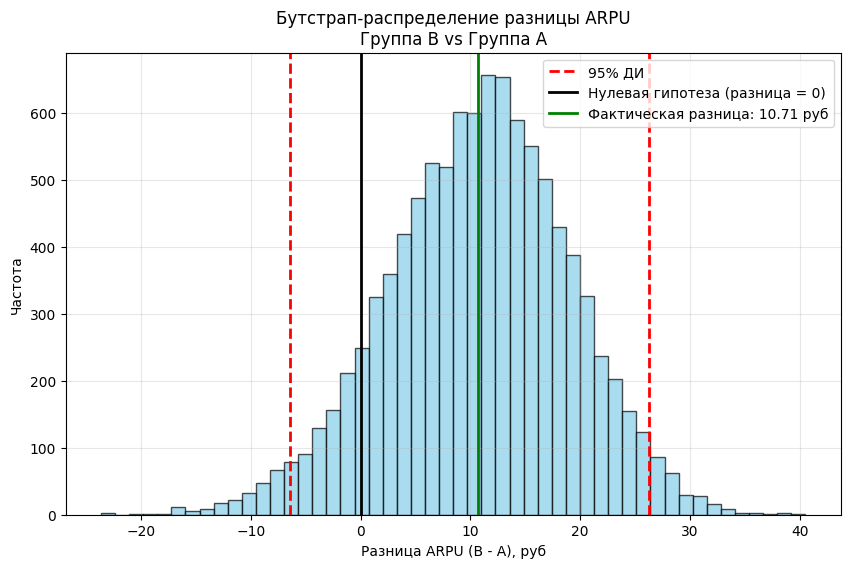


 ВЫВОДЫ:
❌ Разница в ARPU НЕ СТАТИСТИЧЕСКИ ЗНАЧИМА
Наблюдаемое увеличение ARPU может быть случайным и не связано с новой механикой оплаты
Новая механика оплаты  не увеличила общий доход на пользователя
95% Доверительный Интервал [-6.39 руб, 26.29 руб] включает ноль → эффект нестабилен


In [11]:
print("СТАТИСТИЧЕСКАЯ ПРОВЕРКА ARPU")

print("\n  ГИПОТЕЗЫ:")
print("H0: ARPU в группах A и B одинаков")
print("H1: ARPU в группе B выше")

print("\n Для анализа ARPU используем бутстрап-тест, так как распределение доходов ненормальное и содержит много нулевых значений")

print(f"\nИСХОДНЫЕ ДАННЫЕ:")
print(f"Группа A: ARPU = {metrics[metrics['grp'] == 'A']['arpu'].iloc[0]:.2f} руб")
print(f"Группа B: ARPU = {metrics[metrics['grp'] == 'B']['arpu'].iloc[0]:.2f} руб")
print(f"Разница: {metrics[metrics['grp'] == 'B']['arpu'].iloc[0] - metrics[metrics['grp'] == 'A']['arpu'].iloc[0]:.2f} руб")

# Функция для бутстрап-анализа ARPU
def bootstrap_arpu(data_a, data_b, n_bootstrap=10000):
    np.random.seed(42)
    
    boot_diffs = []
    for _ in range(n_bootstrap):
        boot_a = np.random.choice(data_a, len(data_a), replace=True)
        boot_b = np.random.choice(data_b, len(data_b), replace=True)
        boot_diffs.append(np.mean(boot_b) - np.mean(boot_a))
    
    # Односторонний p-value (H1: B > A)
    p_value = np.mean(np.array(boot_diffs) <= 0)
    ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])
    
    return p_value, ci_lower, ci_upper, boot_diffs

# Подготовка данных для ARPU
arpu_a = group_a['rev']  
arpu_b = group_b['rev']  

# Запуск бутстрап-анализа
p_value_arpu, ci_lower_arpu, ci_upper_arpu, boot_diffs_arpu = bootstrap_arpu(arpu_a, arpu_b)

print(f"\n РЕЗУЛЬТАТЫ БУТСТРАП-ТЕСТА ДЛЯ ARPU:")
print(f"P-value: {p_value_arpu:.4f}")
print(f"95% Доверительный интервал: [{ci_lower_arpu:.2f} руб, {ci_upper_arpu:.2f} руб]")
print(f"Статистически значимо: {'✅ ДА' if p_value_arpu < 0.05 else '❌ НЕТ'}")

# Визуализация бутстрап-распределения для ARPU
plt.figure(figsize=(10, 6))
plt.hist(boot_diffs_arpu, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(ci_lower_arpu, color='red', linestyle='--', linewidth=2, label='95% ДИ')
plt.axvline(ci_upper_arpu, color='red', linestyle='--', linewidth=2)
plt.axvline(0, color='black', linewidth=2, label='Нулевая гипотеза (разница = 0)')

actual_diff_arpu = metrics[metrics['grp'] == 'B']['arpu'].iloc[0] - metrics[metrics['grp'] == 'A']['arpu'].iloc[0]
plt.axvline(actual_diff_arpu, color='green', linewidth=2, label=f'Фактическая разница: {actual_diff_arpu:.2f} руб')

plt.xlabel('Разница ARPU (B - A), руб')
plt.ylabel('Частота')
plt.title('Бутстрап-распределение разницы ARPU\nГруппа B vs Группа A')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\n ВЫВОДЫ:")
if p_value_arpu < 0.05:
    print("✅ ARPU в группе B СТАТИСТИЧЕСКИ ЗНАЧИМО выше")
    print(f"   Средний доход на пользователя увеличился на {actual_diff_arpu:.2f} руб")
    print(f"   С 95% уверенностью можно сказать, что истинный эффект находится")
    print(f"   в диапазоне от {ci_lower_arpu:.2f} до {ci_upper_arpu:.2f} руб")
else:
    print("❌ Разница в ARPU НЕ СТАТИСТИЧЕСКИ ЗНАЧИМА")
    print("Наблюдаемое увеличение ARPU может быть случайным и не связано с новой механикой оплаты")
 
print("Новая механика оплаты " + (" увеличила" if p_value_arpu < 0.05 else " не увеличила") + " общий доход на пользователя")
print(f"95% Доверительный Интервал [{ci_lower_arpu:.2f} руб, {ci_upper_arpu:.2f} руб] включает ноль → эффект нестабилен")


СТАТИСТИЧЕСКАЯ ПРОВЕРКА ARPPU

 ГИПОТЕЗЫ:
H0: ARPPU в группах A и B одинаков
H1: ARPPU в группе B выше

Используем бутстрап-тест, так как распределение платежей платящих пользователей не является нормальным и содержит выбросы

  ИСХОДНЫЕ ДАННЫЕ:
Группа A: ARPPU = 934 руб
Группа B: ARPPU = 1258 руб
Разница: 324 руб (+34.7%)

 РЕЗУЛЬТАТЫ БУТСТРАП-ТЕСТА ДЛЯ ARPPU:
P-value: 0.0029
95% Доверительный интервал: [98 руб, 538 руб]
Статистически значимо: ✅ ДА


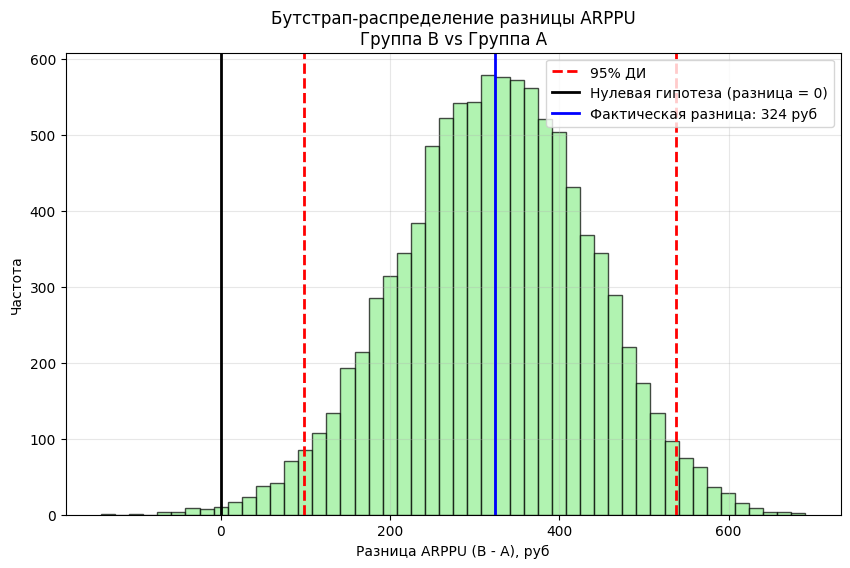


 ВЫВОДЫ:
✅ ARPPU в группе B СТАТИСТИЧЕСКИ ЗНАЧИМО выше
 Средний доход с платящего пользователя увеличился на 324 руб
 С 95% уверенностью можно сказать, что истинный эффект находится
 в диапазоне от 98 до 538 руб
 95% Доверительный Интервал [98 руб, 538 руб] не включает ноль → эффект стабилен
 Новая механика оплаты ЗНАЧИМО УВЕЛИЧИЛА средний доход с платящего пользователя


In [12]:
print("СТАТИСТИЧЕСКАЯ ПРОВЕРКА ARPPU")

print("\n ГИПОТЕЗЫ:")
print("H0: ARPPU в группах A и B одинаков")
print("H1: ARPPU в группе B выше")

print("\nИспользуем бутстрап-тест, так как распределение платежей платящих пользователей не является нормальным и содержит выбросы")

print(f"\n  ИСХОДНЫЕ ДАННЫЕ:")
print(f"Группа A: ARPPU = {metrics[metrics['grp'] == 'A']['arppu'].iloc[0]:.0f} руб")
print(f"Группа B: ARPPU = {metrics[metrics['grp'] == 'B']['arppu'].iloc[0]:.0f} руб")
print(f"Разница: {metrics[metrics['grp'] == 'B']['arppu'].iloc[0] - metrics[metrics['grp'] == 'A']['arppu'].iloc[0]:.0f} руб (+34.7%)")

# Функция для бутстрап-анализа ARPPU
def bootstrap_arppu(data_a, data_b, n_bootstrap=10000):
    np.random.seed(42)
    
    boot_diffs = []
    for _ in range(n_bootstrap):
        boot_a = np.random.choice(data_a, len(data_a), replace=True)
        boot_b = np.random.choice(data_b, len(data_b), replace=True)
        boot_diffs.append(np.mean(boot_b) - np.mean(boot_a))
    
    # Односторонний p-value (H1: B > A)
    p_value = np.mean(np.array(boot_diffs) <= 0)
    ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])
    
    return p_value, ci_lower, ci_upper, boot_diffs

# Подготовка данных для ARPPU (только платящие пользователи)
arppu_a = group_a[group_a['rev'] > 0]['rev']
arppu_b = group_b[group_b['rev'] > 0]['rev']

# Запуск бутстрап-анализа
p_value_arppu, ci_lower_arppu, ci_upper_arppu, boot_diffs_arppu = bootstrap_arppu(arppu_a, arppu_b)

print(f"\n РЕЗУЛЬТАТЫ БУТСТРАП-ТЕСТА ДЛЯ ARPPU:")
print(f"P-value: {p_value_arppu:.4f}")
print(f"95% Доверительный интервал: [{ci_lower_arppu:.0f} руб, {ci_upper_arppu:.0f} руб]")
print(f"Статистически значимо: {'✅ ДА' if p_value_arppu < 0.05 else '❌ НЕТ'}")

# Визуализация бутстрап-распределения для ARPPU
plt.figure(figsize=(10, 6))
plt.hist(boot_diffs_arppu, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(ci_lower_arppu, color='red', linestyle='--', linewidth=2, label='95% ДИ')
plt.axvline(ci_upper_arppu, color='red', linestyle='--', linewidth=2)
plt.axvline(0, color='black', linewidth=2, label='Нулевая гипотеза (разница = 0)')

actual_diff_arppu = metrics[metrics['grp'] == 'B']['arppu'].iloc[0] - metrics[metrics['grp'] == 'A']['arppu'].iloc[0]
plt.axvline(actual_diff_arppu, color='blue', linewidth=2, label=f'Фактическая разница: {actual_diff_arppu:.0f} руб')

plt.xlabel('Разница ARPPU (B - A), руб')
plt.ylabel('Частота')
plt.title('Бутстрап-распределение разницы ARPPU\nГруппа B vs Группа A')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\n ВЫВОДЫ:")
if p_value_arppu < 0.05:
    print("✅ ARPPU в группе B СТАТИСТИЧЕСКИ ЗНАЧИМО выше")
    print(f" Средний доход с платящего пользователя увеличился на {actual_diff_arppu:.0f} руб")
    print(f" С 95% уверенностью можно сказать, что истинный эффект находится")
    print(f" в диапазоне от {ci_lower_arppu:.0f} до {ci_upper_arppu:.0f} руб")
else:
    print("❌ Разница в ARPPU НЕ СТАТИСТИЧЕСКИ ЗНАЧИМА")
    print("  Наблюдаемое увеличение ARPPU может быть случайным и не связано с новой механикой оплаты")

print(f" 95% Доверительный Интервал [{ci_lower_arppu:.0f} руб, {ci_upper_arppu:.0f} руб] {'не включает ноль → эффект стабилен' if ci_lower_arppu > 0 else 'включает ноль → эффект нестабилен'}")

print(" Новая механика оплаты " + ("ЗНАЧИМО УВЕЛИЧИЛА" if p_value_arppu < 0.05 else " НЕ УВЕЛИЧИЛА") + " средний доход с платящего пользователя")

СТАТИСТИЧЕСКАЯ ПРОВЕРКА МЕДИАНЫ ПЛАТЕЖА

 ГИПОТЕЗЫ:
H0: Медиана платежа в группах A и B одинакова
H1: Медиана платежа в группе B выше

Используем бутстрап-тест для разницы медиан, так как распределение платежей ненормальное и содержит выбросы

 ИСХОДНЫЕ ДАННЫЕ:
Группа A: Медиана = 585 руб
Группа B: Медиана = 1140 руб
Разница: 555 руб (+94.9%)

 РЕЗУЛЬТАТЫ БУТСТРАП-ТЕСТА ДЛЯ МЕДИАНЫ:
P-value: 0.0001
95% Доверительный интервал: [320 руб, 1320 руб]
Статистически значимо: ✅ ДА


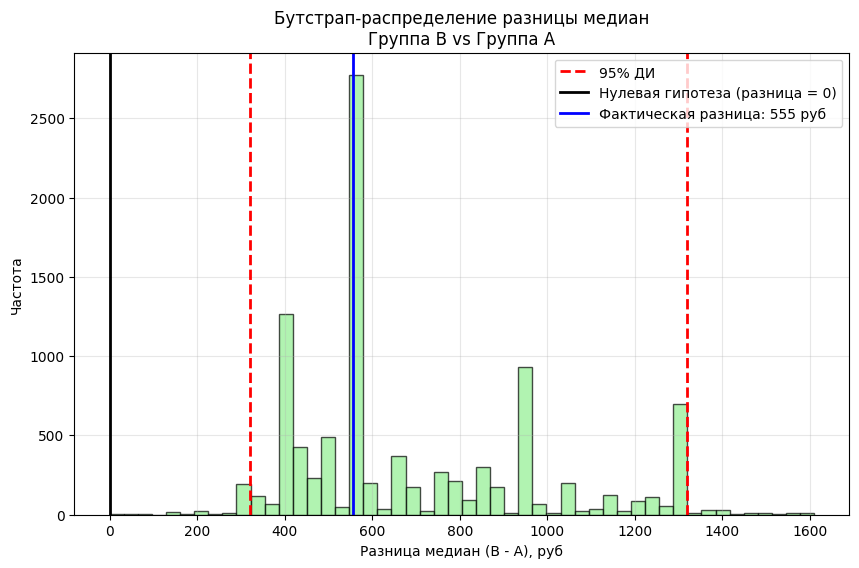


 ВЫВОДЫ:
✅ Медиана платежа в группе B СТАТИСТИЧЕСКИ ЗНАЧИМО выше
 Типичная сумма покупки увеличилась на 555 руб
 С 95% уверенностью можно сказать, что истинный эффект находится
 в диапазоне от 320 до 1320 руб
 95% Доверительный Интервал [320 руб, 1320 руб] не включает ноль → эффект стабилен
 Новая механика оплаты ЗНАЧИМО ИЗМЕНИЛА типичную сумму покупки


In [13]:
print("СТАТИСТИЧЕСКАЯ ПРОВЕРКА МЕДИАНЫ ПЛАТЕЖА")

print("\n ГИПОТЕЗЫ:")
print("H0: Медиана платежа в группах A и B одинакова")
print("H1: Медиана платежа в группе B выше")

print("\nИспользуем бутстрап-тест для разницы медиан, так как распределение платежей ненормальное и содержит выбросы")

print(f"\n ИСХОДНЫЕ ДАННЫЕ:")
print(f"Группа A: Медиана = {metrics[metrics['grp'] == 'A']['median_payment'].iloc[0]:.0f} руб")
print(f"Группа B: Медиана = {metrics[metrics['grp'] == 'B']['median_payment'].iloc[0]:.0f} руб")
print(f"Разница: {metrics[metrics['grp'] == 'B']['median_payment'].iloc[0] - metrics[metrics['grp'] == 'A']['median_payment'].iloc[0]:.0f} руб (+94.9%)")

# Функция для бутстрап-анализа медиан
def bootstrap_median(data_a, data_b, n_bootstrap=10000):
    np.random.seed(42)
    boot_diffs = []
    for _ in range(n_bootstrap):
        boot_a = np.random.choice(data_a, len(data_a), replace=True)
        boot_b = np.random.choice(data_b, len(data_b), replace=True)
        boot_diffs.append(np.median(boot_b) - np.median(boot_a))
    
    # Односторонний p-value (H1: B > A)
    p_value = np.mean(np.array(boot_diffs) <= 0)
    ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])
    
    return p_value, ci_lower, ci_upper, boot_diffs

# Подготовка данных для медианы (только платящие пользователи)
median_a = group_a[group_a['rev'] > 0]['rev']
median_b = group_b[group_b['rev'] > 0]['rev']

# Запуск бутстрап-анализа
p_value_median, ci_lower_median, ci_upper_median, boot_diffs_median = bootstrap_median(median_a, median_b)

print(f"\n РЕЗУЛЬТАТЫ БУТСТРАП-ТЕСТА ДЛЯ МЕДИАНЫ:")
print(f"P-value: {p_value_median:.4f}")
print(f"95% Доверительный интервал: [{ci_lower_median:.0f} руб, {ci_upper_median:.0f} руб]")
print(f"Статистически значимо: {'✅ ДА' if p_value_median < 0.05 else '❌ НЕТ'}")

# Визуализация бутстрап-распределения для медианы
plt.figure(figsize=(10, 6))
plt.hist(boot_diffs_median, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(ci_lower_median, color='red', linestyle='--', linewidth=2, label='95% ДИ')
plt.axvline(ci_upper_median, color='red', linestyle='--', linewidth=2)
plt.axvline(0, color='black', linewidth=2, label='Нулевая гипотеза (разница = 0)')

actual_diff_median = metrics[metrics['grp'] == 'B']['median_payment'].iloc[0] - metrics[metrics['grp'] == 'A']['median_payment'].iloc[0]
plt.axvline(actual_diff_median, color='blue', linewidth=2, label=f'Фактическая разница: {actual_diff_median:.0f} руб')

plt.xlabel('Разница медиан (B - A), руб')
plt.ylabel('Частота')
plt.title('Бутстрап-распределение разницы медиан\nГруппа B vs Группа A')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\n ВЫВОДЫ:")
if p_value_median < 0.05:
    print("✅ Медиана платежа в группе B СТАТИСТИЧЕСКИ ЗНАЧИМО выше")
    print(f" Типичная сумма покупки увеличилась на {actual_diff_median:.0f} руб")
    print(f" С 95% уверенностью можно сказать, что истинный эффект находится")
    print(f" в диапазоне от {ci_lower_median:.0f} до {ci_upper_median:.0f} руб")
else:
    print("❌ Разница в медиане платежа НЕ СТАТИСТИЧЕСКИ ЗНАЧИМА")
    print(" Наблюдаемое увеличение медианы может быть случайным")

print(f" 95% Доверительный Интервал [{ci_lower_median:.0f} руб, {ci_upper_median:.0f} руб] {'не включает ноль → эффект стабилен' if ci_lower_median > 0 else 'включает ноль → эффект нестабилен'}")

print(" Новая механика оплаты " + ("ЗНАЧИМО ИЗМЕНИЛА" if p_value_median < 0.05 else "НЕ ИЗМЕНИЛА") + " типичную сумму покупки")


АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПЛАТЕЖЕЙ

 Цель анализа: сравнить распределение платежей между группами A/B,
выявить типичные суммы транзакций и оценить влияние изменений

 ПОДХОД К АНАЛИЗУ:
• Сравнение гистограмм распределения платежей в группах A и B
• Анализ медианы (типичное значение) и среднего (влияние выбросов)
• Определяем наиболее частые суммы транзакций
• Ищем закономерности в распределении платежей


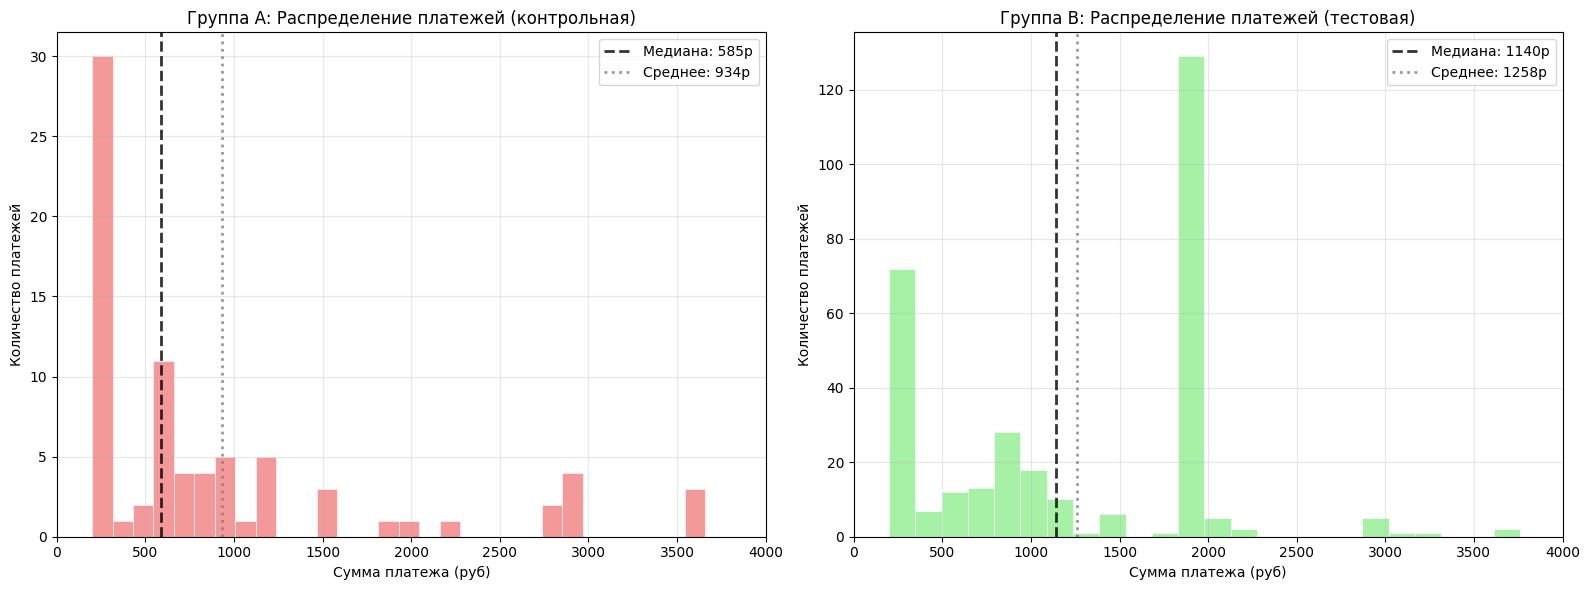


  АНАЛИЗ ПОПУЛЯРНЫХ СУММ ПОКУПОК:
Группа A: самая частая сумма - 290.0 рублей
Группа B: самая частая сумма - 1900.0 рублей

  ВЫВОДЫ ИЗ АНАЛИЗА РАСПРЕДЕЛЕНИЯ:
• В группе B появился новый популярный продукт за ~1900 рублей
• Медиана выросла почти в 2 раза благодаря новому востребованному продукту
• В группе A самый популярный товар за 290 руб
• Пользователи готовы платить больше за новый продукт


In [14]:
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПЛАТЕЖЕЙ")

print("\n Цель анализа: сравнить распределение платежей между группами A/B,")
print("выявить типичные суммы транзакций и оценить влияние изменений")

print("\n ПОДХОД К АНАЛИЗУ:")
print("• Сравнение гистограмм распределения платежей в группах A и B")
print("• Анализ медианы (типичное значение) и среднего (влияние выбросов)")
print("• Определяем наиболее частые суммы транзакций")
print("• Ищем закономерности в распределении платежей")

payers_a = group_a[group_a['rev'] > 0]
payers_b = group_b[group_b['rev'] > 0]

# Создание графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Вычисление статистики
median_a = payers_a['rev'].median()
median_b = payers_b['rev'].median()
mean_a = payers_a['rev'].mean()
mean_b = payers_b['rev'].mean()

# График для группы A
ax1.hist(payers_a['rev'], bins=30, alpha=0.8, color='lightcoral', edgecolor='white', linewidth=0.5)
ax1.axvline(median_a, color='black', linestyle='--', linewidth=2, alpha=0.8, label=f'Медиана: {median_a:.0f}р')
ax1.axvline(mean_a, color='gray', linestyle=':', linewidth=2, alpha=0.8, label=f'Среднее: {mean_a:.0f}р')

ax1.set_xlabel('Сумма платежа (руб)')
ax1.set_ylabel('Количество платежей')
ax1.set_title('Группа A: Распределение платежей (контрольная)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 4000)
ax1.legend()

# График для группы B
ax2.hist(payers_b['rev'], bins=30, alpha=0.8, color='lightgreen', edgecolor='white', linewidth=0.5)
ax2.axvline(median_b, color='black', linestyle='--', linewidth=2, alpha=0.8, label=f'Медиана: {median_b:.0f}р')
ax2.axvline(mean_b, color='gray', linestyle=':', linewidth=2, alpha=0.8, label=f'Среднее: {mean_b:.0f}р')

ax2.set_xlabel('Сумма платежа (руб)')
ax2.set_ylabel('Количество платежей')
ax2.set_title('Группа B: Распределение платежей (тестовая)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 4000)
ax2.legend()

plt.tight_layout()
plt.show()

# Анализ популярных сумм платежей
print(f"\n  АНАЛИЗ ПОПУЛЯРНЫХ СУММ ПОКУПОК:")
print(f"Группа A: самая частая сумма - {payers_a['rev'].mode().iloc[0]} рублей")
print(f"Группа B: самая частая сумма - {payers_b['rev'].mode().iloc[0]} рублей")

print(f"\n  ВЫВОДЫ ИЗ АНАЛИЗА РАСПРЕДЕЛЕНИЯ:")
print("• В группе B появился новый популярный продукт за ~1900 рублей")
print("• Медиана выросла почти в 2 раза благодаря новому востребованному продукту")
print("• В группе A самый популярный товар за 290 руб")
print("• Пользователи готовы платить больше за новый продукт")


АНАЛИЗ ВЛИЯНИЯ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ НА ПЛАТЕЖИ

 ЦЕЛЬ АНАЛИЗА:
Понять, влияет ли активность пользователей (посещение платформы) на:
• Суммы платежей в разных группах
• Эффективность новой механики оплаты

 Если новая механика действительно эффективна, она должна показывать лучшие результаты именно у активных пользователей

АКТИВНЫЕ VS НЕАКТИВНЫЕ ПОЛЬЗОВАТЕЛИ

Всего транзакций: 541
Активные пользователи: 392 (72.5%)
Неактивные пользователи: 149 (27.5%)

МЕДИАННЫЕ СУММЫ ПОКУПОК:
+-----------------------------------+
| Группа |   Активность  | Медиана |
+-----------------------------------+
|   A    |  Неактивные  |    690₽ |
|   A    |   Активные   |    585₽ |
|   B    |  Неактивные  |    690₽ |
|   B    |   Активные   |   1140₽ |
+-----------------------------------+


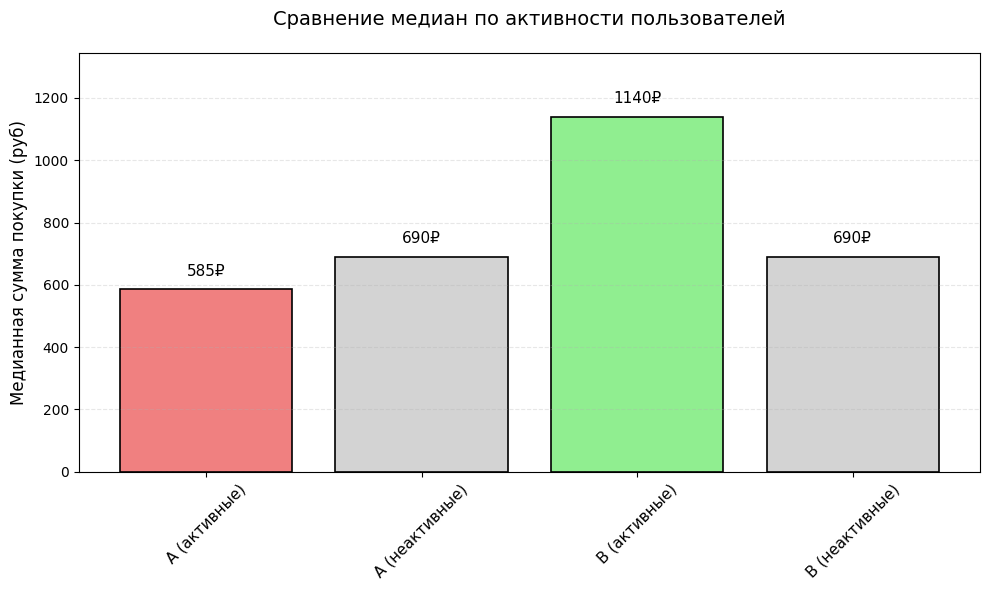


 НАБЛЮДЕНИЯ:
• В группе A: медианы платежей у активных и неактивных пользователей схожи (585₽ vs 690₽)
• В группе B: активные пользователи платят НАМНОГО больше (1140₽ vs 690₽)
• Неактивные пользователи в обеих группах имеют одинаковую медиану (690₽)

  ВЫВОДЫ:
- Новая механика оплаты эффективна именно для АКТИВНЫХ пользователей
- Эффект от механики проявляется только при взаимодействии с платформой
- Неактивные пользователи не реагируют на изменения - их поведение стабильно

 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
• Запустить механику на всех пользователей, но с особым вниманием к активным сегментам
• Усилить работу по вовлечению пользователей для повышения эффективности решения
• Разработать отдельный подход к неактивным пользователям


In [15]:
print("АНАЛИЗ ВЛИЯНИЯ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ НА ПЛАТЕЖИ")

print("\n ЦЕЛЬ АНАЛИЗА:")
print("Понять, влияет ли активность пользователей (посещение платформы) на:")
print("• Суммы платежей в разных группах")
print("• Эффективность новой механики оплаты")

print("\n Если новая механика действительно эффективна, она должна показывать лучшие результаты именно у активных пользователей")

print("\nАКТИВНЫЕ VS НЕАКТИВНЫЕ ПОЛЬЗОВАТЕЛИ")

# Создание таблицы всех пользователей с группами
all_users_with_groups = pd.concat([groups, group_add], ignore_index=True)

# Объединение транзакций с информацией о группах
all_checks_with_groups = checks.merge(all_users_with_groups, left_on='student_id', right_on='id', how='left')

# Определение активных пользователей 
active_users_set = set(active_studs['student_id'])
all_checks_with_groups['is_active'] = all_checks_with_groups['student_id'].isin(active_users_set)

# Общая статистика
total_transactions = len(all_checks_with_groups)
active_transactions = len(all_checks_with_groups[all_checks_with_groups['is_active'] == True])
inactive_transactions = len(all_checks_with_groups[all_checks_with_groups['is_active'] == False])

print(f"\nВсего транзакций: {total_transactions}")
print(f"Активные пользователи: {active_transactions} ({active_transactions/total_transactions*100:.1f}%)")
print(f"Неактивные пользователи: {inactive_transactions} ({inactive_transactions/total_transactions*100:.1f}%)")

# Анализ медианы сумм покупок
median_data = all_checks_with_groups.groupby(['grp', 'is_active'])['rev'].median().reset_index()

print(f"\nМЕДИАННЫЕ СУММЫ ПОКУПОК:")
print("+" + "-"*35 + "+")
print("| Группа |   Активность  | Медиана |")
print("+" + "-"*35 + "+")
for _, row in median_data.iterrows():
    group = row['grp']
    activity = "Активные" if row['is_active'] else "Неактивные"
    median_val = row['rev']
    print(f"|   {group}    | {activity:^12} | {median_val:>6.0f}₽ |")
print("+" + "-"*35 + "+")

# Визуализация сравнения медиан
plt.figure(figsize=(10, 6))  
categories = ['A (активные)', 'A (неактивные)', 'B (активные)', 'B (неактивные)']
medians = [
    median_data[(median_data['grp'] == 'A') & (median_data['is_active'] == True)]['rev'].iloc[0],
    median_data[(median_data['grp'] == 'A') & (median_data['is_active'] == False)]['rev'].iloc[0],
    median_data[(median_data['grp'] == 'B') & (median_data['is_active'] == True)]['rev'].iloc[0],
    median_data[(median_data['grp'] == 'B') & (median_data['is_active'] == False)]['rev'].iloc[0]
]

colors = ['lightcoral', 'lightgray', 'lightgreen', 'lightgray']
bars = plt.bar(categories, medians, color=colors, edgecolor='black', linewidth=1.2)

plt.ylabel('Медианная сумма покупки (руб)', fontsize=12)
plt.title('Сравнение медиан по активности пользователей', fontsize=14, pad=20)
plt.xticks(rotation=45, fontsize=11)

max_median = max(medians)
plt.ylim(0, max_median * 1.18)  

for bar, value in zip(bars, medians):
    plt.text(bar.get_x() + bar.get_width()/2, 
             value + (max_median * 0.03), 
             f'{value:.0f}₽', 
             ha='center', 
             va='bottom',
             fontsize=11)

plt.grid(axis='y', alpha=0.3, linestyle='--') 
plt.tight_layout()
plt.show()

print(f"\n НАБЛЮДЕНИЯ:")
print("• В группе A: медианы платежей у активных и неактивных пользователей схожи (585₽ vs 690₽)")
print("• В группе B: активные пользователи платят НАМНОГО больше (1140₽ vs 690₽)")
print("• Неактивные пользователи в обеих группах имеют одинаковую медиану (690₽)")

print(f"\n  ВЫВОДЫ:")
print("- Новая механика оплаты эффективна именно для АКТИВНЫХ пользователей")
print("- Эффект от механики проявляется только при взаимодействии с платформой")
print("- Неактивные пользователи не реагируют на изменения - их поведение стабильно")

print(f"\n ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
print("• Запустить механику на всех пользователей, но с особым вниманием к активным сегментам")
print("• Усилить работу по вовлечению пользователей для повышения эффективности решения")
print("• Разработать отдельный подход к неактивным пользователям")

In [16]:
print("ФИНАЛЬНЫЕ ВЫВОДЫ")

print("""
1. АНАЛИЗИРУЕМЫЕ МЕТРИКИ И ОБОСНОВАНИЕ:

   Основные метрики:
   • Конверсия - определяет, привлекает ли новая механика больше платящих пользователей
   • ARPPU - ключевая метрика эффективности механики для платежеспособной аудитории
   • Медиана платежа - устойчивый показатель изменения ценового поведения
   • ARPU - общая эффективность монетизации на всех пользователях

   Дополнительные проверки:
   • Анализ распределения платежей - выявил новый продукт ~1900₽ как причину роста
   • Сравнение активных/неактивных пользователей - эффект проявляется только у активных пользователей

2. ОСНОВНЫЕ РАЗЛИЧИЯ И ИХ ПРИЧИНЫ:

   Конверсия:
   Группа A: 5.07% vs Группа B: 4.62% 
   Статистически незначимое снижение (p=0.4455)

   ARPPU и медиана:
   • ARPPU: рост на 34.7% (934₽ → 1258₽), p=0.0029
   • Медиана: рост на 94.9% (585₽ → 1140₽), p=0.0001
   • Причина - новый популярный продукт за 1900₽ в группе B

3. СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:

   • Конверсия: p=0.4455 (не значимо)
   • ARPPU: p=0.0029 (значимо), 95% ДИ [98₽, 538₽]
   • Медиана: p=0.0001 (значимо), 95% ДИ [320₽, 1320₽]
   • ARPU: p=0.0980 (не значимо)

4. ОСОБЕННОСТИ ЭКСПЕРИМЕНТА:

   • Неравномерное распределение групп (4.4:1) с высокой вероятностью не повлияло на основные выводы благодаря:
     - Сильным эффектам (ARPPU +34.7%, медиана +94.9%)
     - Высокой статистической значимости (p < 0.01)
     - Узким доверительным интервалам, не включающим 0
   • Рекомендация: в будущих экспериментах равномерно распределять пользователей 50/50

5. РЕКОМЕНДАЦИИ:

   Основная рекомендация:
   ✅ ЗАПУСКАТЬ новую механику оплаты на всех пользователей

   Обоснование:
   • Статистически значимый рост ARPPU (+34.7%) и медианы (+94.9%)
   • Успешный новый продукт за 1900₽
   • Конверсия осталась на сопоставимом уровне
   • Эффект сильнее проявляется у активных пользователей

   Дополнительные рекомендации:
   • Исправить механизм распределения для будущих A/B тестов
   • Мониторинг ключевых метрик после запуска (2-4 недели)
   • Сфокусироваться на вовлечении активных пользователей
   • Проанализировать успех продукта за 1900₽

6. ЭФФЕКТ ОТ ВНЕДРЕНИЯ:

   Ожидаемые результаты:
   • Рост среднего чека на 324₽ (ARPPU)
   • Увеличение типичной суммы покупки на 555₽ (медиана)
   • Создание нового премиум-сегмента
   • Увеличение общего дохода

   Мониторинг после запуска:
   • Ключевые метрики в течение 2-4 недель (ARPPU, конверсия, медиана)
   • Техническая стабильность платежной системы
   • Пользовательская реакция на изменения

   Критерии успешного внедрения:
   • Сохранение роста ARPPU и медианы
   • Стабильность или рост конверсии
   • Отсутствие массовых жалоб от пользователей
   • Стабильная работа платёжной системы
""")

print("=" * 38)
print("✅ ЗАПУСК НОВОЙ МЕХАНИКИ РЕКОМЕНДОВАН")
print("=" * 38)


ФИНАЛЬНЫЕ ВЫВОДЫ

1. АНАЛИЗИРУЕМЫЕ МЕТРИКИ И ОБОСНОВАНИЕ:

   Основные метрики:
   • Конверсия - определяет, привлекает ли новая механика больше платящих пользователей
   • ARPPU - ключевая метрика эффективности механики для платежеспособной аудитории
   • Медиана платежа - устойчивый показатель изменения ценового поведения
   • ARPU - общая эффективность монетизации на всех пользователях

   Дополнительные проверки:
   • Анализ распределения платежей - выявил новый продукт ~1900₽ как причину роста
   • Сравнение активных/неактивных пользователей - эффект проявляется только у активных пользователей

2. ОСНОВНЫЕ РАЗЛИЧИЯ И ИХ ПРИЧИНЫ:

   Конверсия:
   Группа A: 5.07% vs Группа B: 4.62% 
   Статистически незначимое снижение (p=0.4455)

   ARPPU и медиана:
   • ARPPU: рост на 34.7% (934₽ → 1258₽), p=0.0029
   • Медиана: рост на 94.9% (585₽ → 1140₽), p=0.0001
   • Причина - новый популярный продукт за 1900₽ в группе B

3. СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ:

   • Конверсия: p=0.4455 (не значимо)
 